# Bological representation in database sites

In [1]:
from util import ORIGINAL_PHOSPHOPEDIA_STATISTICS
from util.containers import *
from util.plotting import *

import sqlite3
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Intro:

While tallying the number of sites in the new database is interesting, the represented sites do have biological function, and understanding what sites are present in the database can give a sense of the value of the data. Here, I will be joining the site list against 3rd party data in order to annotate the sites with biological meaning.

## Types of present phosphosites

#### Global site breakdown

In [2]:
%%time
build = DatabaseBuild("data/builds/human_phospho/update_20210902/phosphopedia.db")

Loading PSMs...
Loading Peptides...
Loading Phosphosites
CPU times: user 1min 17s, sys: 5.18 s, total: 1min 22s
Wall time: 3min 49s


In [3]:
def plot_site_makeup(sites):
    residues, counts = np.unique(sites.residue, return_counts=True)
    for r, c in zip(residues, counts):
        print("There are", c, "unique", r, "sites.")
    
    select = np.isin(residues, ["S", "T", "Y"])
    residues, counts = residues[select], counts[select]
    percents = 100*counts/np.sum(counts)
    residues = [aa + " ({:.1f}%)".format(p) for aa, p in zip(residues, percents)]
    
    fig = plt.figure(figsize = (5, 5))
    
    plt.pie(counts,
            labels=residues,
            colors=["#461554", "#56c566", "#30708d"],
            pctdistance=0.7,
            startangle=90,
            wedgeprops={"alpha": .9},
            textprops={"size": 32})
    
    fig.get_axes()[0].spines["right"].set_visible(False)
    fig.get_axes()[0].spines["top"].set_visible(False)

There are 80559 unique S sites.
There are 24392 unique T sites.
There are 11986 unique Y sites.


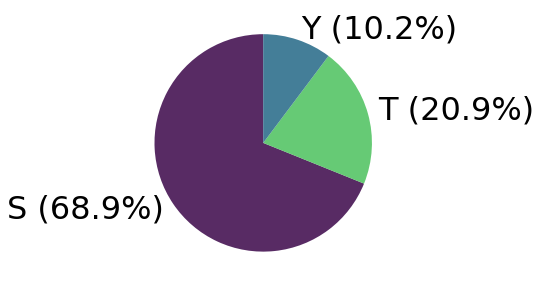

In [4]:
plot_site_makeup(build.sites)
plt.savefig("figures/site_residue_distribution.svg",
            bbox_inches="tight")
plt.show()

This distribution follows sort of what we would expect in that serine outsizes threonine which outsizes tyrosine. There was effort made in this current database to include several phosphotyrosine specific phosphoproteomics datasets. While anecdotal, it does appear that the amount of recovered phosphotyrosine sites is a product of the focus on these datasets, and justifies their continued inclusion.

## SIte Quality

#### Get site/peptide correspondence from build

In [5]:
conn = sqlite3.connect("data/builds/human_phospho/update_20210902/phosphopedia.db")
peptide_to_site = pd.read_sql(
    """
    SELECT s.idSite, p.idPeptide, s.residue, ps.ascore, p.fdr
    FROM site s
    INNER JOIN peptide_site ps
      ON s.idSite = ps.idSite
    INNER JOIN peptide p
      ON ps.idPeptide = p.idPeptide
    WHERE p.fdr < 0.004
    """,
    conn
    )

#### Number of covering peptides

In [6]:
ps_with_counts = peptide_to_site.join(peptide_to_site.groupby("idPeptide").idSite\
                                                     .count()\
                                                     .rename("site_count"),
                                      on = "idPeptide")

peptide_counts = ps_with_counts.groupby(["idSite", "residue"])\
                               .idPeptide\
                               .count()\
                               .rename("peptide_count")\
                               .reset_index()

peptide_counts["censored_count"] = peptide_counts.peptide_count
peptide_counts.censored_count.values[peptide_counts.censored_count > 10] = 10

count_distribution = peptide_counts.groupby(["residue", "censored_count"])\
                                   .idSite\
                                   .count()\
                                   .rename("site_count")\
                                   .reset_index()

count_distribution = count_distribution.join(count_distribution.groupby("residue").site_count\
                                                               .sum()\
                                                               .rename("total_sites"),
                                             on="residue")

count_distribution["site_proportion"] = count_distribution.site_count/count_distribution.total_sites

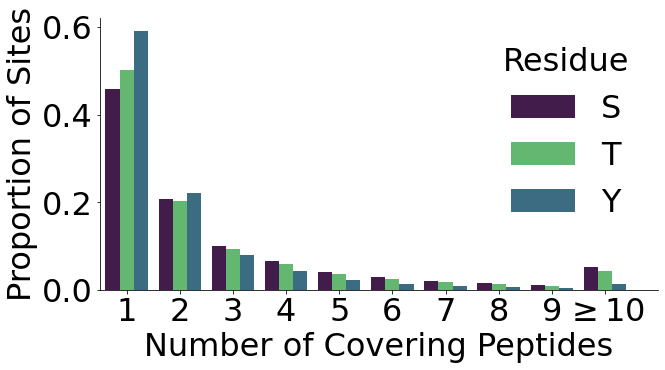

In [7]:
fig = plt.figure(figsize=[10, 5])

sns.barplot(data = count_distribution,
            x = "censored_count",
            y = "site_proportion",
            hue="residue",
            dodge="true",
            palette=["#461554", "#56c566", "#30708d"])

plt.legend(title="Residue",
           title_fontsize=32,
           fontsize=32,
           loc='upper right',
           frameon=False)

plt.xlim(-0.5, 10)
plt.xticks(list(range(10)),
           [str(i) for i in range(1, 10)] + ["$\geq$10"])
plt.xlabel("Number of Covering Peptides", size=32)
plt.ylabel("Proportion of Sites", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/number_of_covering_peptides_by_site.svg")
plt.show()

In many ways, attempting to define the presence of a site purely by its max score isn't entirely as powerful as seeing multiple avenues of peptide evidence for a site. The above plot shows that a large portion of the sites in Phosphopedia are supported by multiple independent peptides, which should give continued confidence in these sites.

#### Breakdown by ascore

In [8]:
site_ascores = peptide_to_site.groupby(["idSite", "residue"]).ascore.max().reset_index()

In [9]:
print("Proportion of sites with Ascore > 13:", np.sum(site_ascores.ascore > 13)/site_ascores.shape[0])

Proportion of sites with Ascore > 13: 0.636552555737046


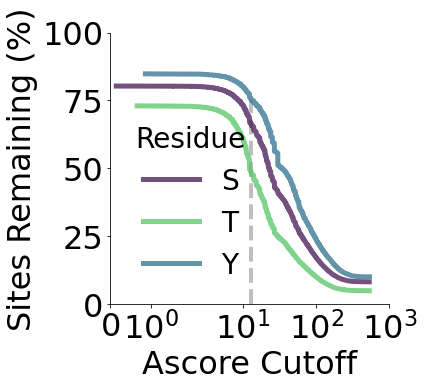

In [10]:
fig = plt.figure(figsize=[5, 5])

for res, col in zip(["S", "T", "Y"], ["#461554", "#56c566", "#30708d"]):
    ascores = site_ascores[site_ascores.residue == res].ascore.sort_values().values
    proportions = 100*(1 - np.arange(ascores.shape[0])/ascores.shape[0])
    select = np.logical_and(ascores > 0., ascores < 1000.)
    plt.plot(ascores[select],
             proportions[select],
             c = col,
             lw = 5,
             alpha=.75,
             label=res
            )

plt.axvline(x=13,
            ymax=.75,
            lw=4,
            linestyle="--",
            color="black",
            alpha=.25,
            zorder=-1)

plt.legend(title="Residue",
           title_fontsize=28,
           fontsize=28,
           loc="lower left",
           frameon=False)

plt.xscale('symlog')
plt.ylim(0, 100)
plt.xlim(0, 1000.)
plt.xlabel("Ascore Cutoff", size=32)
plt.ylabel("Sites Remaining (%)", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)


plt.savefig("figures/sites_remaining_by_ascore.svg")
plt.show()

Many peptides within the database will have almost no localization information. While this is not what we would like, it is the continued price that we pay for looking at areas of the proteome with large stretches of STY sites or other issues which make finding site determining peaks difficult to come by.

#### Peptide count by max ascore

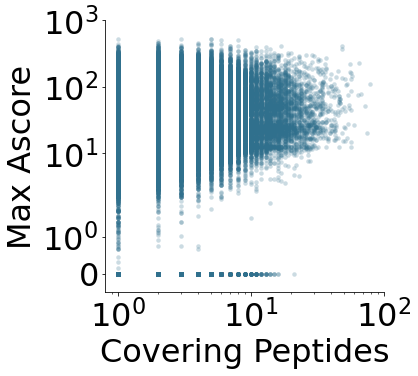

In [11]:
fig = plt.figure(figsize=(5, 5))

sns.scatterplot(data=peptide_counts.join(site_ascores[site_ascores.ascore < 1000.]\
                                                     .set_index("idSite").ascore,
                                         how="inner",
                                         on="idSite"),
                x="peptide_count",
                y="ascore",
                color= "#30708d",
                linewidth=0,
                alpha=.25,
                s=20)

plt.yscale("symlog")
plt.ylim(-.5, 1000)
plt.xscale("log")
plt.xticks([1, 10, 100])
plt.xlabel("Covering Peptides", size=32)
plt.ylabel("Max Ascore", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/ascore_by_number_of_covering_peptides.png",
            bbox_inches="tight")
plt.savefig("figures/ascore_by_number_of_covering_peptides.svg")
plt.show()

There is a very apparent increasing trend in Ascores with increasing number of covering peptides if we look at Ascore < 13. Above that mark, the Ascores don't seem to depend very much on the number of covering peptides. This is caused by two phenomena. The first is that we make an Ascore of 13 the cutoff for calling "localized" in the final calculations. This means that low confidence peptides are collapsed into high confidence peptides. The other phenomena is that peptides have a max Ascore. If there are only 2 theoretical site determining peaks available, there will always be 2 and no more.

## Representation of curated sites

In [12]:
build.sites = pd.read_sql("SELECT idSite, position, residue, fdr, accession, reference"
                          " FROM site, protein WHERE site.idProtein = protein.idProtein", conn)

#### Representation of PhosphositePlus regulatory sites

In [13]:
regulatory_sites = pd.read_csv("data/aux/psp_regulatory_sites.tsv",
                               sep="\t")

regulatory_sites = regulatory_sites[regulatory_sites.ORGANISM == "human"].reset_index()
regulatory_sites["lt_confirmed"] = regulatory_sites.LT_LIT > 0
regulatory_sites["ms_confirmed"] = regulatory_sites.MS_LIT > 0

regulatory_sites["residue"] = regulatory_sites.MOD_RSD.str.replace("[^A-Z].*$", "", regex=True)
regulatory_sites["mod_type"] = regulatory_sites.MOD_RSD.str.replace("^.*-", "", regex=True)
regulatory_sites["position"] = regulatory_sites.MOD_RSD.str.replace("^[A-Z]+", "", regex=True)\
                                                       .str.replace("-.+", "", regex=True)\
                                                       .astype(int)

regulatory_sites = regulatory_sites[regulatory_sites.mod_type == "p"]
regulatory_sites = regulatory_sites[["index", "ACC_ID", "residue", "position", "lt_confirmed", "ms_confirmed"]]

In [14]:
reg_site_coverage = regulatory_sites.join(build.sites.set_index(["accession", "position"]).idSite,
                                          how="inner",
                                          on=["ACC_ID", "position"])

In [15]:
coverage_counts = reg_site_coverage.groupby(["lt_confirmed", "ms_confirmed"])\
                                   .index\
                                   .count()\
                                   .rename("n_detected")\
                                   .reset_index()

coverage_counts = coverage_counts.join(regulatory_sites.groupby(["lt_confirmed", "ms_confirmed"])\
                                                       .index\
                                                       .count()\
                                                       .rename("n_total"),
                                       how="inner",
                                       on=["lt_confirmed", "ms_confirmed"])

In [16]:
coverage_counts

,lt_confirmed,ms_confirmed,n_detected,n_total
0,False,True,37,69
1,True,False,200,2975
2,True,True,3296,6222


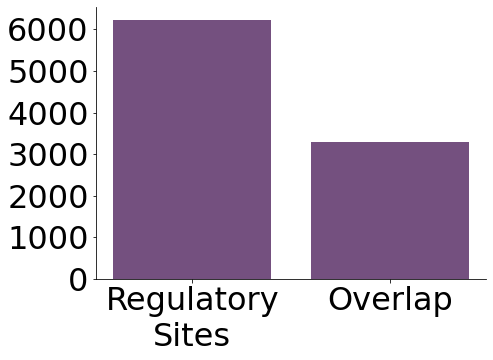

In [17]:
fig = plt.figure(figsize=[7,5])

plt.bar(["Regulatory\nSites", "Overlap"],
        [coverage_counts.n_total.values[-1],
         coverage_counts.n_detected.values[-1]],
        color= "#461554",
        alpha=.75)

plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000])
plt.xlabel("", size=32)
plt.ylabel("", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/number_of_detected_regulatory_sites.svg")
plt.show()

This is great to see. In many cases, the regulatory sites defined by phosphositeplus will not be on peptides which are easy to detect. This means that we are always working at a detriment, and gives us further reason to pursue machine learning bases approaches. However, the fact that we have a large overlap between the 2 lists gives confidence in the database as it is.

#### Representation of krug pathways

In [18]:
pathways = pd.read_csv("data/aux/krug_et_al_site_definitions.csv")
pathways["accession"] = pathways["site.uniprot"].str.replace(";.+", "")
pathways["site"] = pathways["site.uniprot"].str.replace(".+;.", "").astype(int)
pathways = pathways.loc[:, ["signature", "category", "accession", "site"]]

/tmp/282763513.1.sage-login.q/ipykernel_143268/2604710517.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pathways["accession"] = pathways["site.uniprot"].str.replace(";.+", "")
/tmp/282763513.1.sage-login.q/ipykernel_143268/2604710517.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  pathways["site"] = pathways["site.uniprot"].str.replace(".+;.", "").astype(int)


In [19]:
to_filt = pathways.join(build.sites.set_index(["accession", "position"]).residue,
                        on=["accession", "site"],
                        how="inner")

to_filt[to_filt.category == "PATH-WP"].signature.unique()

array(['PATH-WP_Ras_Signaling',
       'PATH-WP_Pancreatic_adenocarcinoma_pathway',
       'PATH-WP_Non-small_cell_lung_cancer',
       'PATH-WP_MFAP5-mediated_ovarian_cancer_cell_motility_and_invasiveness',
       'PATH-WP_MAPK_Signaling_Pathway', 'PATH-WP_Endometrial_cancer',
       'PATH-WP_Chromosomal_and_microsatellite_instability_in_colorectal_cancer',
       'PATH-WP_Breast_cancer_pathway',
       'PATH-WP_PI3K-Akt_Signaling_Pathway', 'PATH-WP_Cell_Cycle',
       'PATH-WP_LncRNA_involvement_in_canonical_Wnt_signaling_and_colorectal_cancer',
       'PATH-WP_Wnt_Signaling_Pathway',
       'PATH-WP_Epithelial_to_mesenchymal_transition_in_colorectal_cancer'],
      dtype=object)

In [20]:
coverage = pd.merge(pathways.join(build.sites.set_index(["accession", "position"]).residue,
                                       on=["accession", "site"],
                                       how="inner")\
                            .groupby(["category", "signature"])\
                            .site\
                            .count()\
                            .rename("detected_sites")\
                            .reset_index(),
                    pathways.groupby(["category", "signature"])\
                            .site\
                            .count()\
                            .rename("total_sites")\
                            .reset_index(),
                    how="outer").fillna(0)

In [21]:
order = ["KINASE-PSP", "PERT-PSP",
         "PATH-NP", "PATH-WP", 
         "PERT-P100-PRM", "PERT-P100-DIA"]

coverage["order"] = [order.index(x) for x in coverage.category]
coverage = coverage.sort_values("order")

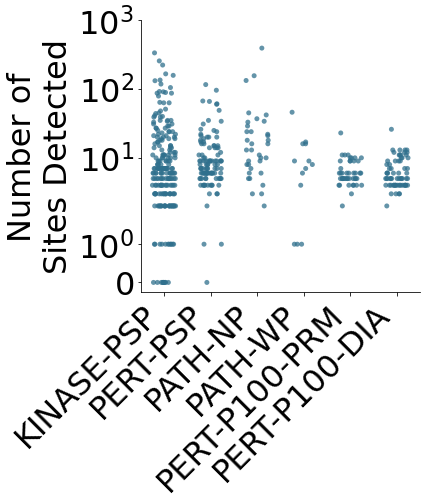

In [22]:
fig = plt.figure(figsize = [5, 5])

sns.stripplot(data=coverage,
              x="category",
              y="detected_sites",
              jitter=.25,
              alpha=.75,
              color="#30708d")

plt.xticks(rotation=45, ha='right', )
plt.ylim(-.25, 1000)
plt.yscale("symlog")
plt.tick_params(labelsize=32)

plt.xlabel("")
plt.ylabel("Number of\nSites Detected", size=32)
plt.tick_params(labelsize=32)
    
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/coverage_of_curated_sites.svg")
plt.show()

In many cases, individuals will not know which peptides they are looking for, but may have a rough idea of the pathway of interest. By including the above pathays as database queries, users will have a much easier time building assays without having to have all the information curated for themselves.